<a href="https://colab.research.google.com/github/chang-heekim/Dacon_Competition/blob/main/Sign_Language_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!unzip user_data.zip

In [1]:
from glob import glob 
import os 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.utils.data import Dataset
from PIL import Image

from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch import nn, optim
from torchsummary import summary
import torch.nn.functional as F
import torchvision.models as models

In [2]:
train_df = pd.read_csv('train.csv')

mapping = {'1' : '0', '2' : '1', '3' : '2',
           '4' : '3', '5' : '4', '6' : '5',
           '7' : '6', '8' : '7', '9' : '8',
           '10-1' : '9', '10-2' : '10'}
train_df.label = train_df.label.map(mapping)
train_df

,file_name,label
0,001.png,10
1,002.png,9
2,003.png,2
3,004.png,7
4,005.png,8
...,...,...
853,854.png,8
854,855.png,0
855,856.png,3
856,857.png,9


In [66]:
img_pathes = glob('train/*.png')
test_img_pathes = glob('test/*.png') 
labels = train_df.label.astype(np.int8).to_numpy()

(224, 224, 3)


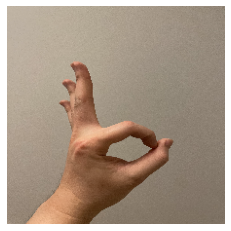

In [67]:
image = Image.open(f'/content/train/001.png')
image = np.array(image)
print(image.shape)
plt.imshow(image)
plt.axis('off')
plt.show()

In [68]:
class Sign_Language_Dataset(Dataset):
    def __init__(self, img_pathes, labels=None, transform=None, target_transform=None, mode='train'):
        super().__init__()

        self.img_pathes = img_pathes
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode

    def __len__(self):
        return len(self.img_pathes)

    def __getitem__(self, idx):
        if self.mode == 'train':
            img_path = self.img_pathes[idx]
            label = self.labels[idx]
            img = Image.open(img_path)
            if self.transform:
                img = self.transform(img)

            return img, label
        
        else:
            img_path = self.img_pathes[idx]
            img = Image.open(img_path)
            if self.transform:
                img = self.transform(img)
            return img

In [69]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                      
])

dataset = Sign_Language_Dataset(img_pathes, labels, transform=transform)

for _ in range(9):
    dataset += Sign_Language_Dataset(img_pathes, labels, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_batch_size = 16
val_batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2)

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet = models.resnet50()
resnet.fc = nn.Linear(2048, 11)

# vgg = models.vgg13_bn(pretrained=False)
# vgg.classifier[6].out_features = 11

model = resnet.to(device)
# model = vgg.to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
epochs = 50

for epoch in range(1, epochs + 1):
    print(f' Epoch: [{epoch}/{epochs}] - Train')
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
        current_loss = 0.0
        currnet_correct = 0.0
        
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)
        

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item() 
        currnet_correct += torch.sum(preds == labels.data) 

        if (idx + 1) % 100 == 0:
            train_loss = current_loss / train_batch_size
            train_acc = currnet_correct / train_batch_size
            print(f'Current Step: {idx + 1} \tTrain Loss: {train_loss}, Train Accuracy: {train_acc}')
            current_loss = 0.0
            currnet_correct = 0.0

    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0.0
        for val_idx, (val_images, val_labels) in enumerate(val_loader):
            val_labels = val_labels.type(torch.LongTensor)
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
            val_correct += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / len(val_loader)

    print(f'    Validation step: Val Loss: {val_epoch_loss}, Val Accuracy: {val_epoch_acc}')

 Epoch: [1/50] - Train
Current Step: 100 	Train Loss: 0.1612546443939209, Train Accuracy: 0.1875
Current Step: 200 	Train Loss: 0.15295536816120148, Train Accuracy: 0.125
Current Step: 300 	Train Loss: 0.1446048766374588, Train Accuracy: 0.125
Current Step: 400 	Train Loss: 0.15263688564300537, Train Accuracy: 0.1875
    Validation step: Val Loss: 0.1529383659362793, Val Accuracy: 0.14004629850387573
 Epoch: [2/50] - Train
Current Step: 100 	Train Loss: 0.14549732208251953, Train Accuracy: 0.0625
Current Step: 200 	Train Loss: 0.15059426426887512, Train Accuracy: 0.125
Current Step: 300 	Train Loss: 0.13909076154232025, Train Accuracy: 0.25
Current Step: 400 	Train Loss: 0.1533021777868271, Train Accuracy: 0.25
    Validation step: Val Loss: 0.1494216024875641, Val Accuracy: 0.1979166716337204
 Epoch: [3/50] - Train
Current Step: 100 	Train Loss: 0.15324190258979797, Train Accuracy: 0.1875
Current Step: 200 	Train Loss: 0.1402984857559204, Train Accuracy: 0.125
Current Step: 300 	Train

In [72]:
test_dataset = Sign_Language_Dataset(test_img_pathes, None, transform=test_transform, mode='test')
test_loader = DataLoader(test_dataset, batch_size=43, shuffle=False, num_workers=0)

In [73]:
answers = []
with torch.no_grad():
    for test_idx, test_images in enumerate(test_loader):
        test_images = test_images.to(device)

        test_outputs = model(test_images)
        _, answer = torch.max(test_outputs, 1)
        answers.extend(answer.detach().cpu().numpy()) 

In [74]:
sub = pd.read_csv('sample_submission.csv')
sub['label'] = answers

reverse_mapping = {v: k for k, v in mapping.items()}

sub['label'] = sub['label'].apply(lambda x: str(x))
sub['label'] = sub['label'].map(reverse_mapping)

In [75]:
sub.to_csv('submission.csv', index=False)